In [4]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import itertools

In [140]:
# Load results from wandb
api = wandb.Api()
user_name = "dhdhagar"
project_name = "ttt-arc"
runs = api.runs(f"{user_name}/{project_name}")
expected_n_results = 54
all_targets = [
   '00576224',
   '0c786b71',
   '0c9aba6e',
   '17cae0c1',
   '195ba7dc',
   '2072aba6',
   '27a77e38',
   '281123b4',
   '31d5ba1a',
   '32e9702f',
   '34b99a2b',
   '3b4c2228',
   '3d31c5b3',
   '48131b3c',
   '4852f2fa',
   '4cd1b7b2',
   '506d28a5',
   '5783df64',
   '59341089',
   '5d2a5c43',
   '60c09cac',
   '626c0bcc',
   '62b74c02',
   '66e6c45b',
   '66f2d22f',
   '68b67ca3',
   '6a11f6da',
   '6ad5bdfd',
   '6ea4a07e',
   '7953d61e',
   '833dafe3',
   '8597cfd7',
   '8ba14f53',
   '9110e3c5',
   'a8610ef7',
   'aa18de87',
   'af24b4cc',
   'b0722778',
   'b1fc8b8e',
   'bbb1b8b6',
   'be03b35f',
   'c074846d',
   'c8b7cc0f',
   'ca8de6ea',
   'd017b73f',
   'd19f7514',
   'e133d23d',
   'e345f17b',
   'e633a9e5',
   'e6de6e8f',
   'e99362f0',
   'ed74f2f2',
   'ed98d772',
   'fc754716'
]

In [144]:
# Get runs by tags
tags = None
all_tags = [
   ["sft"], ["sft", "train_temp=sched"], ["pro", "oracle"], ["pro", "online"], ["sft", "pro", "oracle"],
   ["grpo", "oracle"], ["grpo", "online"], ["grpo", "beta0", "oracle"]
]

In [145]:
# Load results
results = []
for run in runs:
    # if all(tag in run.tags for tag in tags):
    if (tags is None and any(set(run.tags) == set(t) for t in all_tags)) or (tags is not None and set(run.tags) == set(tags)):
        results.append({
            "target": run.config["target"],
            "tags": ",".join(sorted(set(run.tags))),
            **run.summary
        })

# Convert results into dataframe
all_res_df = pd.DataFrame(results)

if tags is not None:
   assert len(all_res_df) == expected_n_results, f"Expected {expected_n_results} results, got {len(all_res_df)} results. Missing targets: {set(all_targets) - set(all_res_df.target.tolist())}"

# Convert any boolean datatypes to int
for col in all_res_df.columns:
    if all_res_df[col].dtype == bool:
        all_res_df[col] = all_res_df[col].astype(int)

# Columns to show
cols_to_show = ["tags", "target", "_runtime", "test/solved_majority", "test/solved_majority_pass2", "test/solved_oracle", "test/best_score", "validation/majority_reward", "validation/majority_count", "train/reward_minus_replacement_mean", "train/reward_minus_replacement_max"]
numerical_cols = ["_runtime", "test/solved_majority", "test/solved_majority_pass2", "test/solved_oracle", "test/best_score", "validation/majority_reward", "validation/majority_count", "train/reward_minus_replacement_mean", "train/reward_minus_replacement_max"]

res_df = all_res_df[cols_to_show]

In [151]:
# # Show results for one configuration
# res_df.describe()

# Show all results
_res_df = res_df[['tags'] + numerical_cols].groupby("tags").mean()
_res_df = _res_df.sort_values(["test/solved_majority_pass2", "test/solved_majority", "test/solved_oracle", "test/best_score"], ascending=True)
# Add a count column as the 1st column
_res_df.insert(0, "count", res_df[['tags', 'target']].groupby("tags").count())
_res_df

,count,_runtime,test/solved_majority,test/solved_majority_pass2,test/solved_oracle,test/best_score,validation/majority_reward,validation/majority_count,train/reward_minus_replacement_mean,train/reward_minus_replacement_max
tags,,,,,,,,,,
"online,pro",54,282.565988,0.296296,0.425926,0.481481,0.858366,0.767570,17.314815,0.653914,0.755778
"grpo,online",54,430.278034,0.314815,0.425926,0.462963,0.870253,0.789387,16.759259,0.653499,0.746892
"oracle,pro",54,242.486204,0.351852,0.481481,0.537037,0.899679,0.823586,18.740741,0.728166,0.831245
sft,54,131.012640,0.351852,0.518519,0.555556,0.878520,0.788739,18.092593,0.731850,0.731850
"oracle,pro,sft",54,219.020248,0.370370,0.518519,0.574074,0.911957,0.803357,17.777778,0.734850,0.848389
"sft,train_temp=sched",54,172.410281,0.388889,0.518519,0.574074,0.898320,0.769897,18.333333,0.725364,0.725364
"grpo,oracle",54,354.452279,0.388889,0.537037,0.592593,0.889481,0.784964,18.351852,0.786376,0.899993
"beta0,grpo,oracle",9,218.096819,0.333333,0.555556,0.555556,0.868227,0.771605,14.777778,0.795422,0.867284


In [147]:
# Export this dataframe as a markdown table
_md_table = res_df[['tags'] + numerical_cols].groupby("tags").mean()
_md_table = _md_table.sort_values("test/solved_majority_pass2", ascending=True)
print(_md_table.to_markdown(index=True))

| tags                 |   _runtime |   test/solved_majority |   test/solved_majority_pass2 |   test/solved_oracle |   test/best_score |   validation/majority_reward |   validation/majority_count |   train/reward_minus_replacement_mean |   train/reward_minus_replacement_max |
|:---------------------|-----------:|-----------------------:|-----------------------------:|---------------------:|------------------:|-----------------------------:|----------------------------:|--------------------------------------:|-------------------------------------:|
| grpo,online          |    430.278 |               0.314815 |                     0.425926 |             0.462963 |          0.870253 |                     0.789387 |                     16.7593 |                              0.653499 |                             0.746892 |
| online,pro           |    282.566 |               0.296296 |                     0.425926 |             0.481481 |          0.858366 |                     0.76757  |  

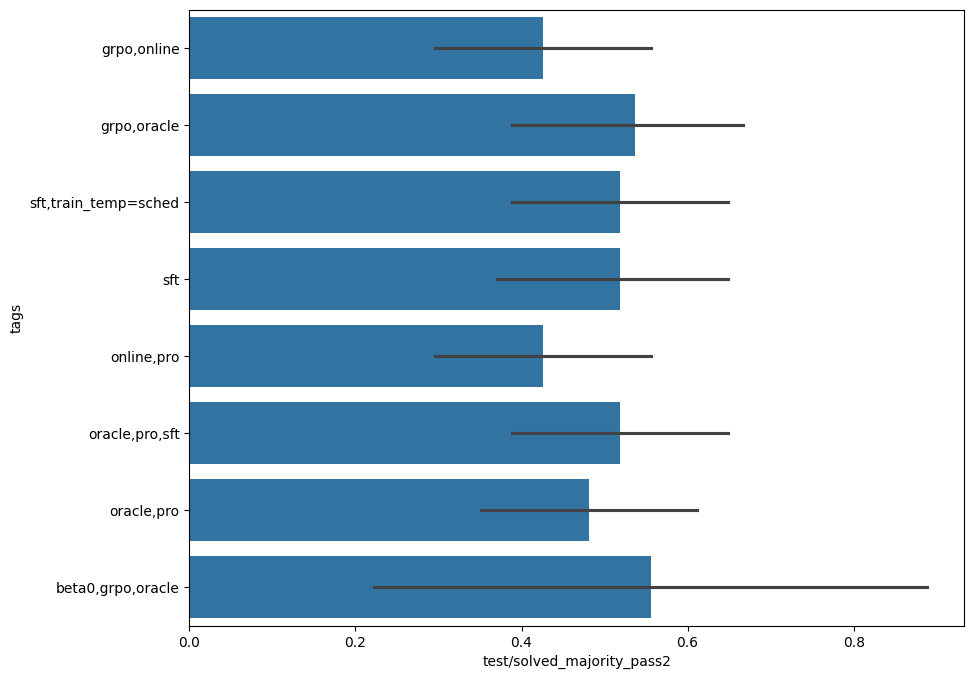

In [148]:
# Plot results
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=res_df, x="test/solved_majority_pass2", y="tags", ax=ax)
plt.show()
